<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/fakeclinicalnotes/src/cogs402projecttestnotes/example_attn_plot_featuring_downsizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This short notebook simply converts the attention output of the Longformer model into a traditional seq_len x seq_len format and plots the attention using matplotlib.

### Import and Install Dependencies

In [ ]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [ ]:
pip install datasets --quiet

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Import Dataset and Model

Remember to adjust the path for the models and dataset and change the max_length accordingly.

In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

def longformer_finetuned_papers():
    model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned_papers_v2', num_labels = 2, output_attentions = True)
    return model

def preprocess_function(tokenizer, example, max_length):
    example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
    return example

def get_papers_dataset(dataset_type):
    max_length = 512
    dataset = load_dataset("danielhou13/cogs402dataset")[dataset_type]

    # tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)
    setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
    setattr(dataset, 'target_columns', ['labels'])
    setattr(dataset, 'max_length', max_length)
    setattr(dataset, 'tokenizer', tokenizer)
    return dataset

def papers_validation_set():
    return get_papers_dataset('validation')

In [ ]:
# def preprocess_function(tokenizer, example, max_length):
#     example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
#     return example

# def longformer_finetuned_news():
#     model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned-news-cogs402', num_labels = 2)
#     return model

# def get_news_dataset(dataset_type):
#     max_length = 2048
#     dataset = load_dataset("danielhou13/cogs402dataset2")[dataset_type]

#     tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
#     dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)

#     labels = map(int, dataset['hyperpartisan'])
#     print(type(dataset['hyperpartisan']))
#     labels = list(labels)
#     dataset = dataset.add_column("labels", labels)

#     dataset = dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
#     print(dataset)
#     setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
#     setattr(dataset, 'target_columns', ['labels'])
#     setattr(dataset, 'max_length', max_length)
#     setattr(dataset, 'tokenizer', tokenizer)
#     return dataset

# def news_train_set():
#     return get_news_dataset('train')

# def news_test_set():
#     return get_news_dataset('validation')

In [ ]:
cogs402_test = papers_validation_set()
model = longformer_finetuned_papers()
columns = cogs402_test.input_columns + cogs402_test.target_columns
print(columns)
cogs402_test.set_format(type='torch', columns=columns)
cogs402_test=cogs402_test.remove_columns(['text'])

  0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at danielhou13/longformer-finetuned_papers_v2 were not used when initializing LongformerForSequenceClassification: ['longformer.embeddings.position_ids']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['input_ids', 'attention_mask', 'labels']


In [ ]:
if torch.cuda.is_available():
    model = model.cuda()

print(model.device)

cuda:0


### Evaluate example 

Replace number in testval with whatever example you wish to evaluate.

In [ ]:
test_val = [976]
testexam = cogs402_test[test_val]

In [ ]:
# print(test['labels'][923])

We do the forward pass of our model and grab the attentions, stacking them to create a tensor of shape: (layer, batch, head, seq_len, x + sliding_window_attention + 1). x is the number of tokens with global attention. The global attention is a tensor of shape (layer, batch, head, seq_len, x).

In [ ]:
output = model(testexam["input_ids"].cuda(), attention_mask=testexam['attention_mask'].cuda(), labels=testexam['labels'].cuda(), output_attentions = True)
batch_attn = output[-2]
output_attentions = torch.stack(batch_attn).cpu()
global_attention = output[-1]
output_global_attentions = torch.stack(global_attention).cpu()
print("output_attention.shape", output_attentions.shape)
print("gl_output_attention.shape", output_global_attentions.shape)

output_attention.shape torch.Size([12, 1, 12, 512, 514])
gl_output_attention.shape torch.Size([12, 1, 12, 512, 1])


In [ ]:
# print(os.getcwd())
# yes = torch.load("resources/longformer_test2/epoch_3/aggregate_attn.pt")

Convert sliding attention matrix to correct seq_len x seq_len matrix. The full details of these functions can be found [here](https://colab.research.google.com/drive/1Kxx26NtIlUzioRCHpsR8IbSz_DpRFxEZ#scrollTo=liVhkxiH9Le0). A brief summary of these functions are that they change the output attention tensor of shape (layer, batch, head, seq_len, x + attention_window + 1) and a global attention tensor of shape (layer, batch, head, seq_len, x) to a single ndarray of shape (layer, batch, head, seq_len, seq_len).

In [ ]:
def create_head_matrix(output_attentions, global_attentions):
    new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
    for i in range(output_attentions.shape[0]):
        test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
        test2 = output_attentions[i][test_non_zeroes[1:]]
        new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
        new_attention_matrix[i][new_attention_matrix_indices] = test2
        new_attention_matrix[i][0] = output_attentions[i][0]
        new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
    return new_attention_matrix.detach().cpu().numpy()


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = create_head_matrix(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)


def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = all_batches(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

In [ ]:
converted_mat = all_layers(output_attentions, output_global_attentions)
print(converted_mat.shape)

(12, 1, 12, 512, 512)


The following block is the normalization code by T3-vis. It operates by converting the values into colour values which we can use for plotting. For each layer and head in the complete attention matrix, we take the (seq_len, seq_len) matrix, normalize all the values, then scale it so each value is between 0-255. Arrays of the same shape representing colour channels are then made, and the colours we do not want are masked and set to 0. Finally we stack our 4 matrices so that each item in our original array now contains 4 colour values (red, blue, green, alpha). We then convert this into a list, keeping the 4 colour values of each item sequential. 

**The input is an array of shape: (layer, batch, head, seq_len, seq_len)**. 

**The output shape is a (4 x layer x batch x head x seq_len x seq_len) list**

The aggregated attention contains layer x batch x head x seq_len x seq_len values in the attention matrix and there are 4 colour channels: red, blue, green, alpha (controls how opaque the colour is).

In [ ]:
def format_attention_image(attention):
    formatted_attn = []
    for layer_idx in range(attention.shape[0]):
        print("layer", layer_idx)
        for head_idx in range(attention.shape[1]):
            formatted_entry = {
                'layer': layer_idx,
                'head': head_idx
            }

            # Flatten value of log attention normalize between 255 and 0
            if len(attention[layer_idx, head_idx]) == 0:
                continue
            attn = np.array(attention[layer_idx, head_idx]).flatten()
            attn = (attn - attn.min()) / (attn.max() - attn.min())
            alpha = np.round(attn * 255)
            red = np.ones_like(alpha) * 255
            green = np.zeros_like(alpha) * 255
            
            blue = np.zeros_like(alpha) * 255

            attn_data = np.dstack([red,green,blue,alpha]).reshape(alpha.shape[0] * 4).astype('uint8')
            formatted_entry['attn'] = attn_data.tolist()
            formatted_attn.append(formatted_entry)
    return formatted_attn

In [ ]:
example_attention = format_attention_image(converted_mat.squeeze())

layer 0
layer 1
layer 2
layer 3
layer 4
layer 5
layer 6
layer 7
layer 8
layer 9
layer 10
layer 11


In [ ]:
# def section_avg(matrix, row, col):
#   row_sections = row
#   column_sections = col
#   sh = row,matrix.shape[0]//row, col, matrix.shape[1]//col, -1
#   final = matrix.reshape(sh).mean(-2).mean(1)
#   print(matrix.reshape(sh).mean(-2).mean(1))
#   return final

Functions we use to downsize

In [ ]:
# get a subset of the matrix based on the new pixel size
# if the slice is at the end of the row or column, we take the remaining pixels and at it to the slice
def get_slice(matrix, row, col, row_stride, col_stride, row_end, col_end):
  if (row_end and col_end):
    return matrix[row*row_stride:, col*col_stride:]
  elif row_end:
    return matrix[row*row_stride:, col*col_stride:col*col_stride+col_stride]
  elif col_end:
    return matrix[row*row_stride:row*row_stride+row_stride, col*col_stride:]
  else:
    return matrix[row*row_stride:row*row_stride+row_stride, col*col_stride:col*col_stride+col_stride]

def find_average(matrix):
  #find how many reds and blues there are
  red_count = np.count_nonzero(matrix[:,:,-1][matrix[:,:,0] == 255])
  blue_count = np.count_nonzero(matrix[:,:,-1][matrix[:,:,2] == 255])

  # count number of zeros
  zeros_count = matrix[:,:,-1][matrix[:,:,-1] == 0].shape[0]

  #add up the totals for all the reds and blues
  red_sum = 0
  blue_sum = 0
  assert ((zeros_count + red_count + blue_count) == (matrix.shape[0] * matrix.shape[1]))
  #if the total number of reds are not 0, sum up the red total
  if (red_count != 0):
    red_sum = np.sum(matrix[:,:,3][matrix[:,:,0] == 255])
    red_avg = red_sum/(matrix.shape[0] * matrix.shape[1])
  
  #if the total number of blues are not 0, sum up the blue total
  if (blue_count != 0):
    blue_sum = np.sum(matrix[:,:,3][matrix[:,:,2] == 255])
    blue_avg = blue_sum/(matrix.shape[0] * matrix.shape[1])

  # if both red and blue are 0, then its an empty space
  if (red_count == 0 and blue_count == 0):
    return np.array((0,0,0,0))
  #if blue is 0 then just average up red
  elif (blue_count == 0):
    return np.array((255,0,0, red_avg))
  #if red is 0 then just average up blue
  elif (red_count == 0):
    return np.array((0,0,255, blue_avg))
  #if red average is greater than blue average then return red average (penalized by blue average)
  elif (red_avg > blue_avg):
    return np.array((255,0,0, red_avg - blue_avg))
  #if blue average is greater than red average, then return blue average (penalized by red average)
  else:
    return np.array((0,0,255, blue_avg - red_avg))


def section_conv(matrix, row_stride, col_stride):
  # pass in the (N, M, 4) matrix we are working with and the number of pixels
  # you want to reduce the rows/columns by

  # Input matrix size: (N, M, 4)
  # Output matrix size: (N//row_stride, M//col_stride, 4)

  #get number of rows and column numbers based on how many pixels per section
  row = matrix.shape[0] // row_stride
  col = matrix.shape[1] // col_stride

  #initialize a new array to return
  new_array = np.empty((row,col,4))

  for i in range(row):
    # check if its the end of a row or column for slice method
    row_end = (i == (row-1))
    for j in range(col):
      col_end = (j == (col-1))

      # get the slice we are working with
      section_curr = get_slice(matrix, i, j, row_stride, col_stride, row_end, col_end)
      #get the average and add it into the new array
      new_array[i, j] = find_average(section_curr)

  if (row == 1) and (col == 1):
    return new_array

  # normalize if needed
  new_array[:,:,3] = (new_array[:,:,3] - np.min(new_array[:,:,3])) / (np.max(new_array[:,:,3]) - np.min(new_array[:,:,3]))
  new_array[:,:,3] *= 255
  return new_array

In [ ]:
a = np.array(example_attention[4]['attn']).reshape((512,512,4))
a[:,::2, [0,2]] = [0,255]
b = np.ndarray.astype(section_conv(a,4,4), "uint8")

AssertionError: ignored

In [ ]:
a[:,:,-1][a[:,:,-1] == 0].shape

(64771,)

In [ ]:
np.count_nonzero(a[:,:,-1][a[:,:,0] == 255])

98560

In [ ]:
a[:,:,-1][a[:,:,0] == 255].shape

(131072,)

In [ ]:
np.count_nonzero(a[:,:,-1][a[:,:,2] == 255])

98813

In [ ]:
a[:,:,-1][a[:,:,2] == 255].shape

(131072,)

In [ ]:
# from skimage.transform import rescale, resize, downscale_local_mean

# image_downscaled = downscale_local_mean(a, (2, 2, 1))
# print(image_downscaled)

To visualize the attention, we use matplotlib to plot out the attention matrix. First, we get an attention matrix from the above list from range [0 ... head x layer - 1] where every 12 items is a new layer. For example, item 0 is "layer 1 head 1" and item 12 is "layer 2 head 1". Note that we have to use the `attn` key to grab the matrix. Then we reshape the matrix from a 4 x seq_len x seq_len list to an array of shape (seq_len, seq_len, 4). 


Then, with matplotlib's [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function, it plots a 2-D heatmap of shape (seq_len, seq_len). The darker the part of the image looks on the heatmap, the higher the amount of attention between the tokens.

The block of code below demonstrates how to get plot one specific head from one layer.

Layer (row): 0 Head (col): 2


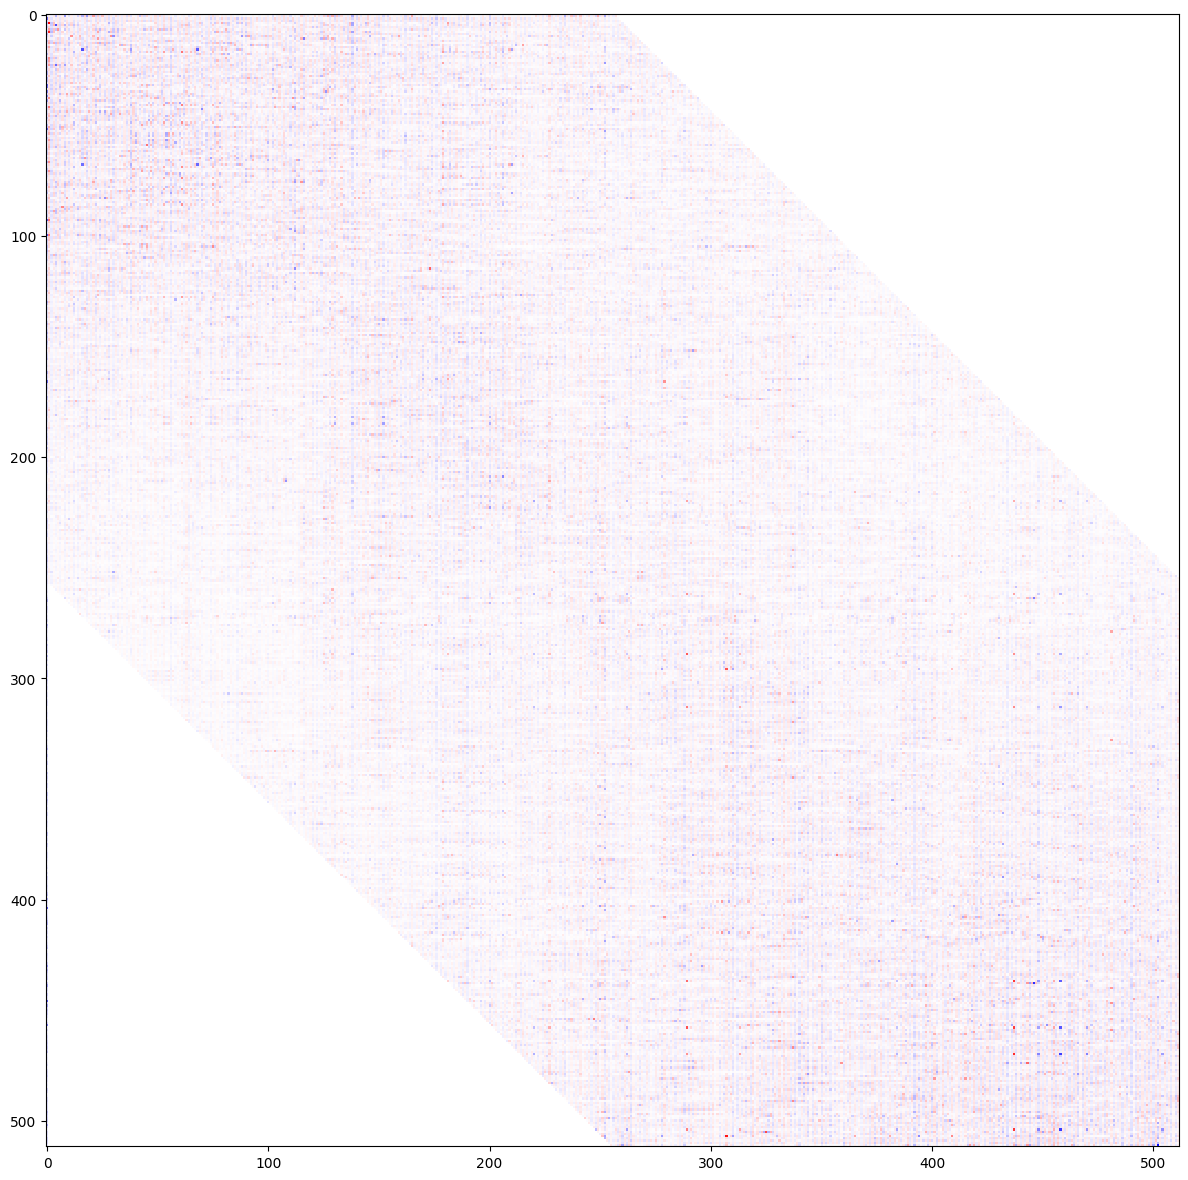

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

#replace 0 with the matrix you wish to visualize

a = np.array(example_attention[2]['attn']).reshape((512,512,4))
a[:,::2, [0,2]] = [0,255]

example = example_attention[2]
col_num = example['head']
row_num = example['layer']
print("Layer (row):", row_num, "Head (col):", col_num)
c = ax.imshow(a, interpolation="nearest")

# ax.set_xticks([])
# ax.set_yticks([])

plt.show()

Layer (row): 0 Head (col): 2



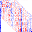

In [ ]:
from matplotlib import pyplot as plt
import plotly.express as px

# plt.rcParams['figure.dpi'] = 100
# fig, ax = plt.subplots()
# fig.set_figheight(15)
# fig.set_figwidth(15)

#replace 0 with the matrix you wish to visualize

a = np.array(example_attention[2]['attn']).reshape((512,512,4))
a[:,::2, [0,2]] = [0,255]
b = np.ndarray.astype(section_conv(a, 16, 16), "uint8")

example = example_attention[2]
col_num = example['head']
row_num = example['layer']
print("Layer (row):", row_num, "Head (col):", col_num)
c = px.imshow(b, width = 1400, height = 1080)

# ax.set_xticks([])
# ax.set_yticks([])

c.show()

We have functionally the same code as the previous block, but here we are plotting every attention matrix (all 144 in our code). With 12 heads and 12 layers, the key difference is we have to keep track of the current row (layers) and column (head). Thankfully, the function above lets us store the head and the layer. 

With 12 heads per layer, we create a new row every 12 plots. Then, we can plot the matrix at the correct slot using matplotlib's subplot (axs in our code).

Lastly, we delete the current item in the list after plotting to free up memory given the large array size we are working with.

100%|██████████| 144/144 [00:19<00:00,  7.54it/s]


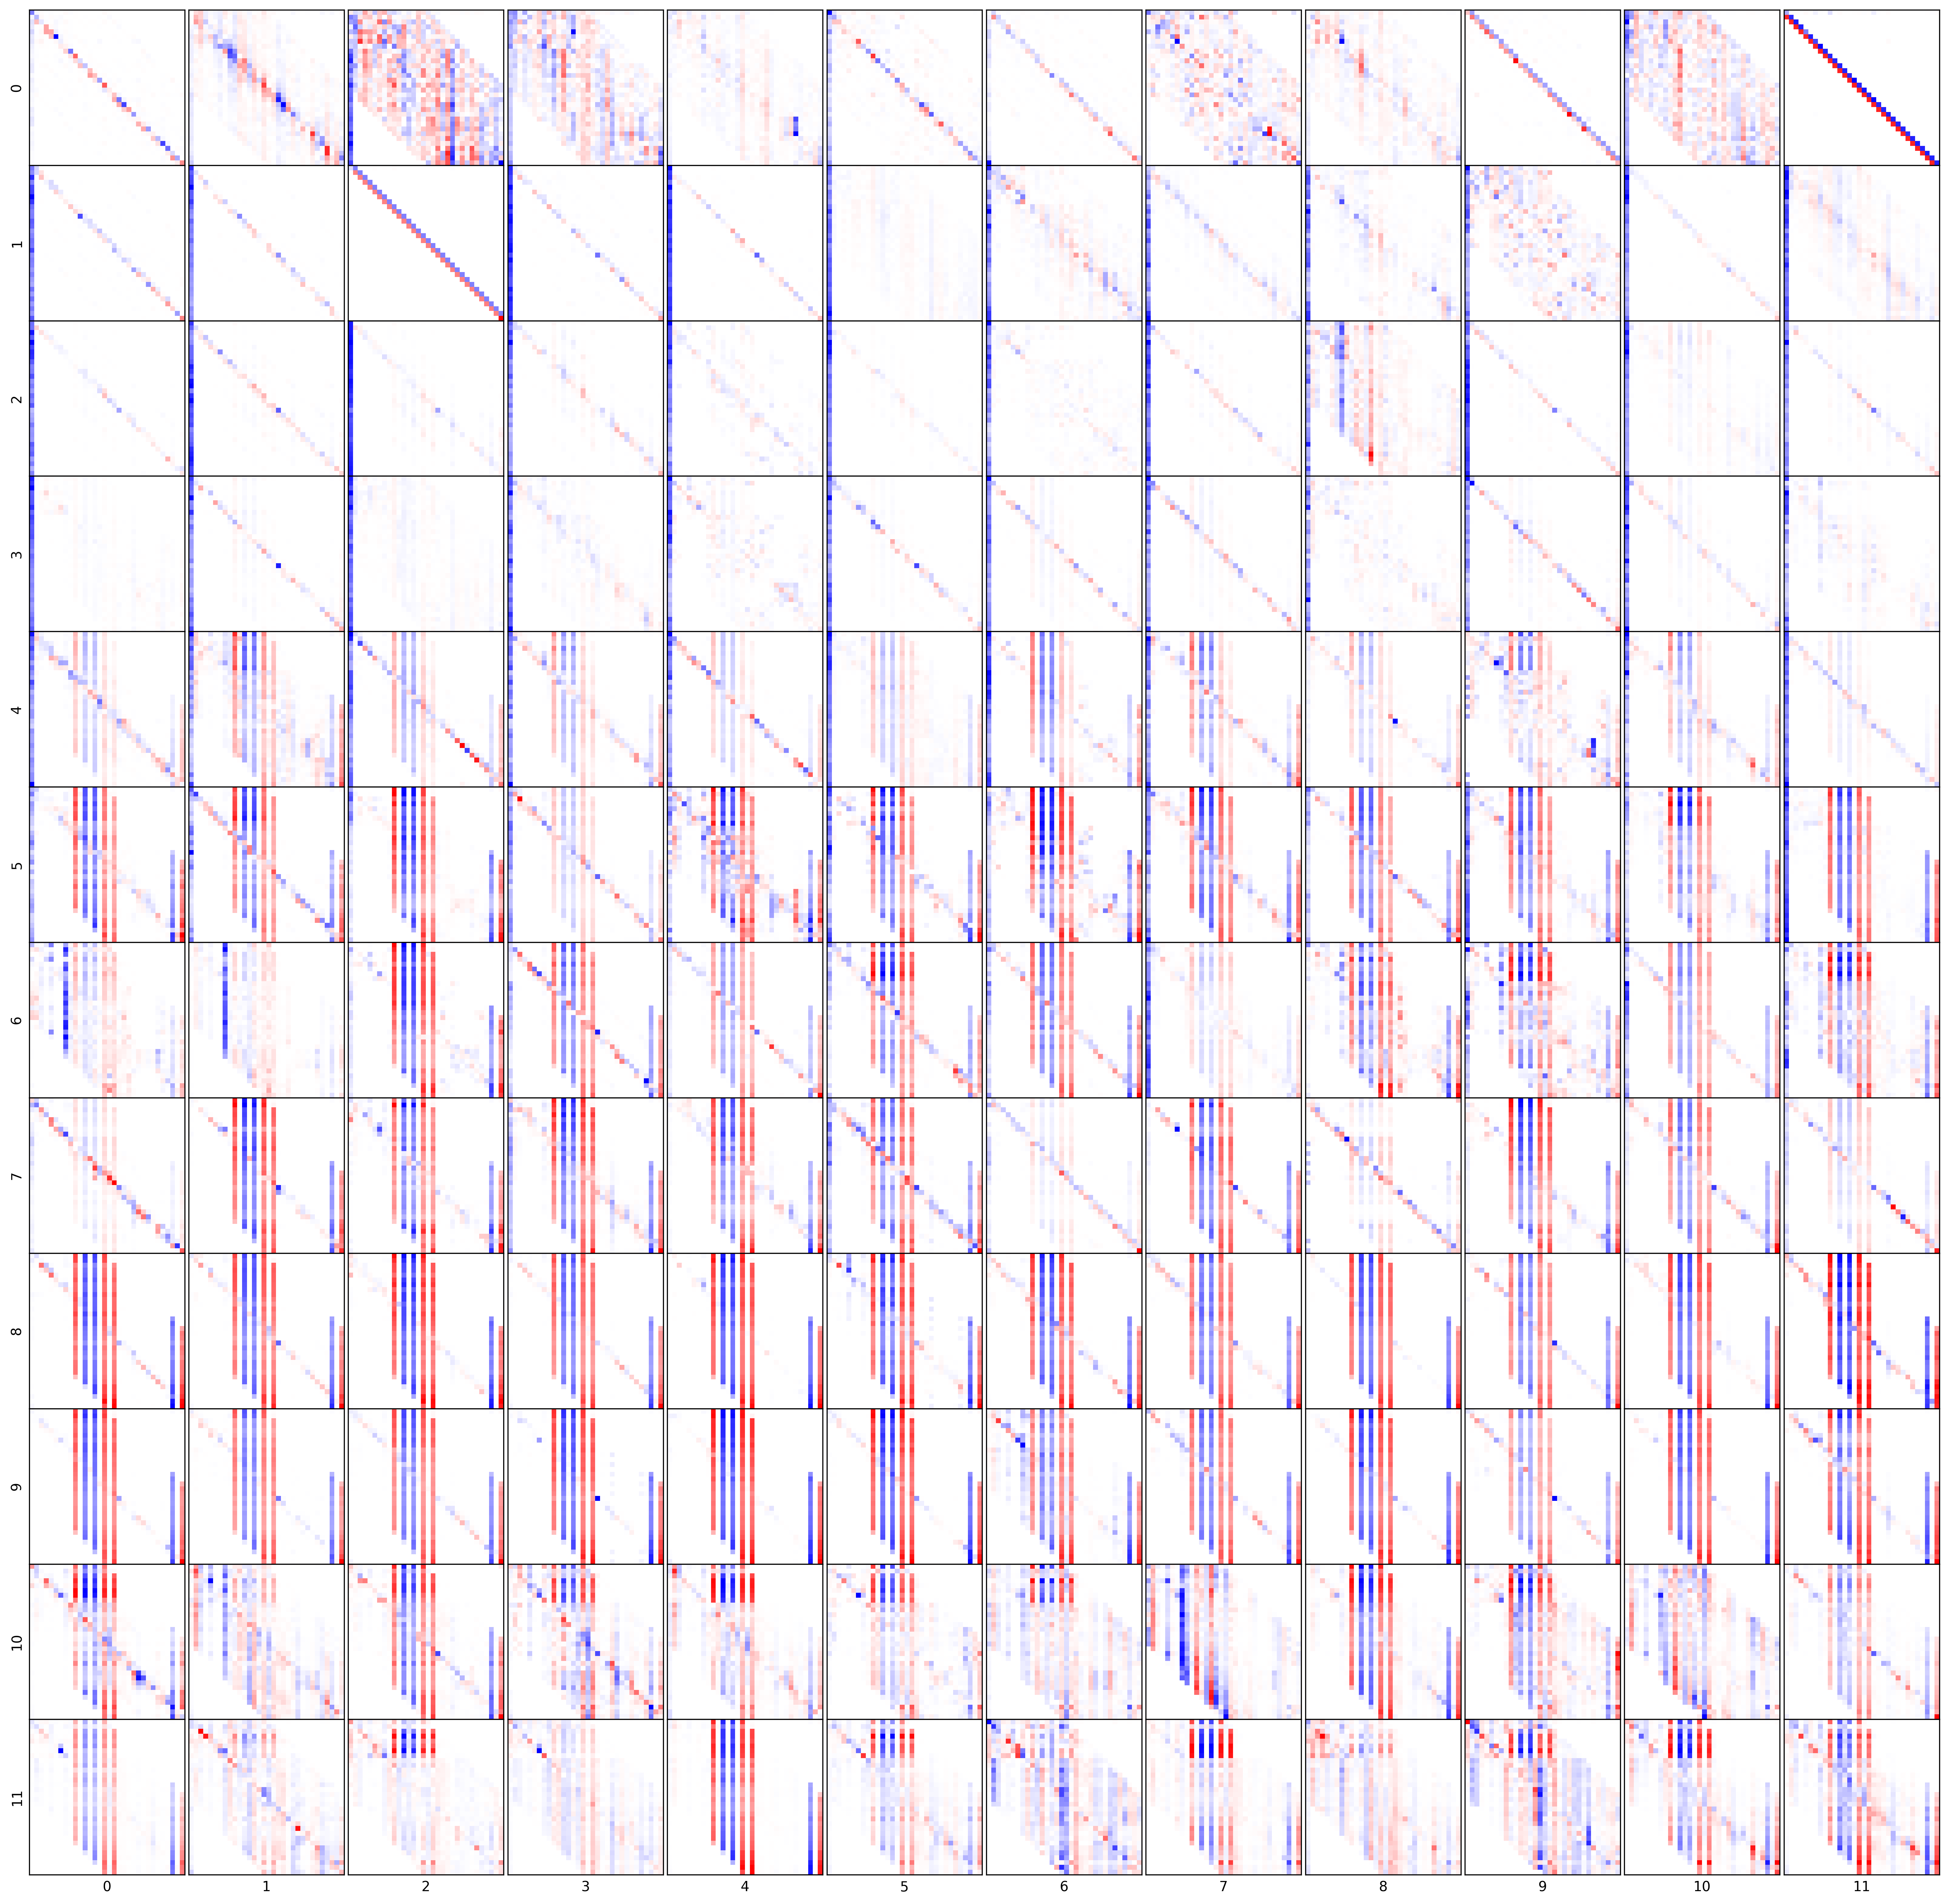

In [ ]:
import math 
from tqdm import tqdm

plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(12,12,figsize=(25,25))
row_num=0
for i in tqdm(range(len(example_attention))):
    test2 = np.array(example_attention[i]['attn']).reshape((512,512,4))
    col_num = example_attention[i]['head']
    row_num = example_attention[i]['layer']
    test2[:,::2, [0,2]] = [0,255]
    b = np.ndarray.astype(section_conv(test2,16,16), "uint8")

    c= axs[row_num, col_num].imshow(b, interpolation="nearest")
    axs[row_num, col_num].set(xlabel = str(col_num), ylabel = str(row_num))
    axs[row_num, col_num].xaxis.set_ticks([])
    axs[row_num, col_num].yaxis.set_ticks([])
    # del(example_attention[0])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('exampleattnheatmap.pdf')
plt.show()

100%|██████████| 144/144 [00:21<00:00,  6.79it/s]



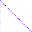
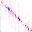
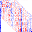
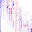
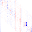
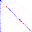
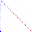
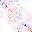
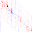
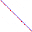
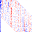
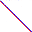
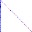
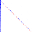
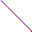
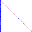
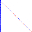
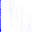
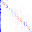
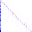
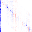
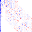
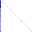
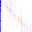
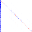
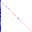
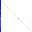
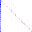
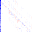
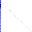
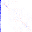
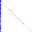
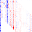
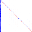
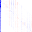
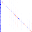
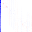
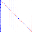
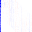
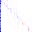
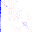
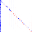
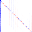
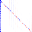
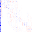
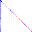
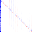
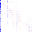
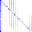
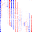
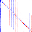
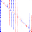
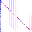
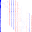
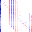
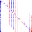
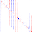
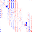
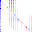
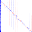
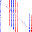
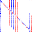
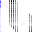
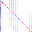
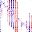
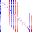
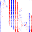
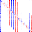
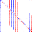
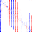
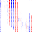
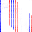
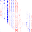
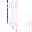
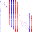
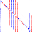
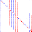
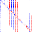
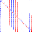
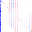
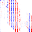
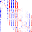
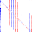
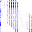
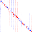
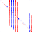
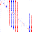
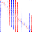
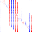
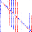
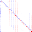
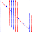
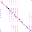
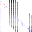
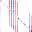
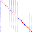
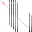
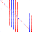
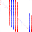
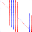
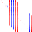
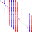
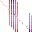
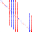
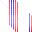
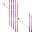
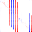
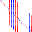
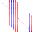
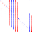
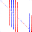
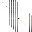
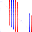
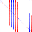
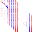
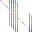
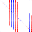
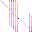
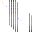
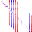
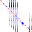
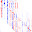
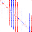
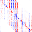
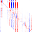
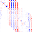
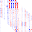
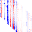
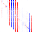
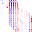
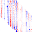
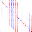
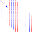
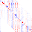
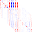
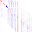
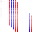
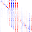
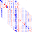
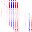
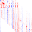
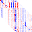
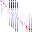
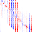

In [ ]:
import math 
from tqdm import tqdm
from plotly.subplots import make_subplots

row_title = ["layer 1", "layer 2", "layer 3","layer 4", 
             "layer 5", "layer 6", "layer 7", "layer 8", 
             "layer 9", "layer 10", "layer 11", "layer 12"]

column_title = ["head 1", "head 2", "head 3" ,"head 4", 
                "head 5", "head 6", "head 7", "head 8", 
                "head 9", "head 10", "head 11", "head 12"]

fig = make_subplots(rows=12, cols=12, x_title="heads", y_title="layers", 
                    column_titles=column_title, row_titles=row_title,
                    vertical_spacing=0.02, horizontal_spacing = 0.02)

for i in tqdm(range(len(example_attention))):
    test2 = np.array(example_attention[i]['attn']).reshape((512,512,4))
    col_num = example_attention[i]['head']
    row_num = example_attention[i]['layer']
    test2[:,::2, [0,2]] = [0,255]
    b = np.ndarray.astype(section_conv(test2,16,16), "uint8")

    fig.add_trace(px.imshow(b).data[0],
              row=row_num+1, col=col_num + 1)
    
fig.update_layout(height=1500, width=1500)
fig.show()